# Project Goal

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user adoption .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler


from scipy.stats import chi2_contingency

# Data Wrangling

In [2]:
user_df = pd.read_csv("takehome_users.csv")
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
engagement_df = pd.read_csv("takehome_user_engagement.csv")
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Handle Missing values

In [4]:
user_df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

- `last_session_creation_time` represents the unix  timestamp  of  last  login, so we can assume if a user never logged back in after they first created account, the value will be null
- `invited_by_user_id` can be null if the user is not invited by anyone
Therefore, will convert the columns to boolean features of `login_created` and `invited`

In [5]:
user_df['login_created'] = ~user_df['last_session_creation_time'].isnull()
user_df['invited'] = ~user_df['invited_by_user_id'].isnull()
user_df.drop(columns=['last_session_creation_time', 'invited_by_user_id'], inplace=True)
user_df.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
login_created                 0
invited                       0
dtype: int64

In [6]:
engagement_df.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

### Check duplicates

In [7]:
user_df.duplicated().any()

False

In [8]:
engagement_df.duplicated().any()

False

### Correct data type

In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   object_id                   12000 non-null  int64 
 1   creation_time               12000 non-null  object
 2   name                        12000 non-null  object
 3   email                       12000 non-null  object
 4   creation_source             12000 non-null  object
 5   opted_in_to_mailing_list    12000 non-null  int64 
 6   enabled_for_marketing_drip  12000 non-null  int64 
 7   org_id                      12000 non-null  int64 
 8   login_created               12000 non-null  bool  
 9   invited                     12000 non-null  bool  
dtypes: bool(2), int64(4), object(4)
memory usage: 773.6+ KB


In [10]:
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])
user_df['name'] = user_df['name'].astype('string')
user_df['email'] = user_df['email'].astype('string')
user_df['creation_source'] = user_df['creation_source'].astype('category')
user_df['opted_in_to_mailing_list'] = user_df['opted_in_to_mailing_list'].astype('bool')
user_df['enabled_for_marketing_drip'] = user_df['enabled_for_marketing_drip'].astype('bool')
user_df.rename(columns={'object_id': 'user_id'}, inplace=True)
user_df.set_index('user_id', inplace=True)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  string        
 2   email                       12000 non-null  string        
 3   creation_source             12000 non-null  category      
 4   opted_in_to_mailing_list    12000 non-null  bool          
 5   enabled_for_marketing_drip  12000 non-null  bool          
 6   org_id                      12000 non-null  int64         
 7   login_created               12000 non-null  bool          
 8   invited                     12000 non-null  bool          
dtypes: bool(4), category(1), datetime64[ns](1), int64(1), string(2)
memory usage: 527.6 KB


In [11]:
user_df.head()

,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,login_created,invited
user_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,True,False,11,True,True
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,False,False,1,True,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,False,False,94,True,True
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,False,False,1,True,True
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,False,False,193,True,True


In [12]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
engagement_df['visited'] = engagement_df['visited'].astype('bool')
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 3.4 MB


### Feature Engineering

In [13]:
# Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period
user_visits = engagement_df.groupby('user_id')['time_stamp'].apply(list)

def is_adopted(visits):
    visits = sorted(visits)
    if len(visits) < 3:
        return False
    else:
        for i in range(len(visits)-2):
            if (visits[i+2] - visits[i]).days <=7:
                return True
        return False
    
users_adopted = user_visits.apply(is_adopted).reset_index()
users_adopted.columns=['user_id', 'adopted']
users_adopted.set_index('user_id', inplace=True)
users_adopted.head()

,adopted
user_id,
1,False
2,True
3,False
4,False
5,False


In [14]:
user_df = user_df.join(users_adopted, how='left', on='user_id')

In [15]:
user_df['adopted'] = user_df['adopted'].fillna(False)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  string        
 2   email                       12000 non-null  string        
 3   creation_source             12000 non-null  category      
 4   opted_in_to_mailing_list    12000 non-null  bool          
 5   enabled_for_marketing_drip  12000 non-null  bool          
 6   org_id                      12000 non-null  int64         
 7   login_created               12000 non-null  bool          
 8   invited                     12000 non-null  bool          
 9   adopted                     12000 non-null  bool          
dtypes: bool(5), category(1), datetime64[ns](1), int64(1), string(2)
memory usage: 539.3 KB


/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_34960/1356793998.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_df['adopted'] = user_df['adopted'].fillna(False)


In [16]:
user_df.head()

,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,login_created,invited,adopted
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,True,False,11,True,True,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,False,False,1,True,True,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,False,False,94,True,True,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,False,False,1,True,True,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,False,False,193,True,True,False


# EDA

In [17]:
def plot_adoption_by_category(categoryStr):
    adoptedByCategory = user_df.groupby([categoryStr, 'adopted']).size().unstack()
    adoptedRate = adoptedByCategory[True] / (adoptedByCategory[False] + adoptedByCategory[True]) * 100    
    adoptedRate = adoptedRate.fillna(0)
    
    fig, ax1 = plt.subplots(figsize=(8, 4))
    adoptedByCategory.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_xlabel(categoryStr)
    ax1.set_ylabel('Number of Users')
    ax1.set_title(f"Adoption by {categoryStr}")
    plt.xticks(rotation=45)
    
    for index, row in adoptedByCategory.iterrows():
        adopted_count = row[True] if pd.notna(row[True]) else 0
        unadopted_count = row[False] if pd.notna(row[False]) else 0
        total = adopted_count + unadopted_count
        
        # Get the positions of the bars
        pos = list(adoptedByCategory.index).index(index)  # Get the index position of the category in custom order
        
        # Annotate unretained count
        ax1.text(pos, unadopted_count / 2, f'{int(unadopted_count)}', ha='center', va='center', color='white', fontsize=10)
        
        # Annotate retained count
        ax1.text(pos, unadopted_count + adopted_count / 2, f'{int(adopted_count)}', ha='center', va='center', color='white', fontsize=10)
        
        # Annotate total count above the bar
        ax1.text(pos, total, f'Total: {int(total)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax2 = ax1.twinx()
    ax2.plot(adoptedRate.index, adoptedRate.values, color='red', marker='o', label='Adopted Rate')
    ax2.set_ylabel('Adopted Rate (%)')
    ax2.legend(loc='upper right')
               
    plt.show()

In [18]:
def chiSquaredTest(categoryStr):
    contingency_table = pd.crosstab(user_df[categoryStr], user_df['adopted'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)

    print(f"Chi-Squared Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")

    # Interpretation
    if p < 0.05:
        print(f"Reject the null hypothesis: There is a significant difference in adoption rates across {categoryStr}.")
    else:
        print(f"Fail to reject the null hypothesis: No significant difference in adoption rates across {categoryStr}.")

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_34960/1186313712.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adoptedByCategory = user_df.groupby([categoryStr, 'adopted']).size().unstack()


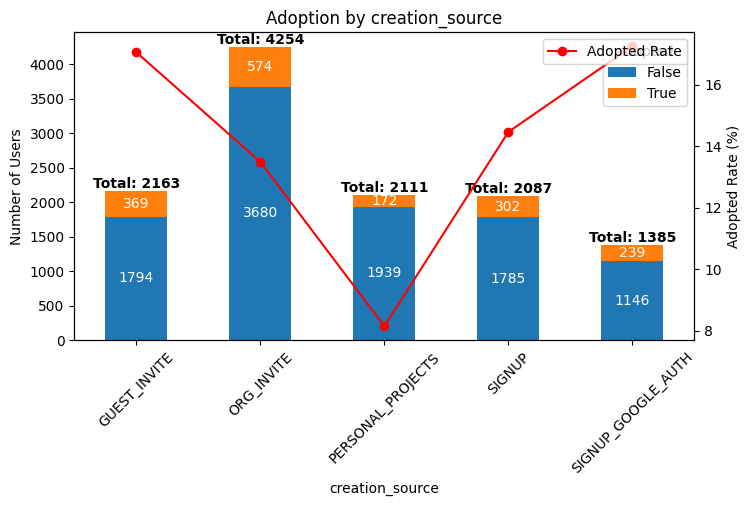

Chi-Squared Statistic: 91.04842041636412
P-Value: 7.884346873316259e-19
Degrees of Freedom: 4
Reject the null hypothesis: There is a significant difference in adoption rates across creation_source.


In [19]:
plot_adoption_by_category('creation_source')
chiSquaredTest('creation_source')

The `guest_invite` and `signup_google_auth` has the highest adoption rate, despite having the lowest total users. `personal_projects` has the lowest adoption rate.

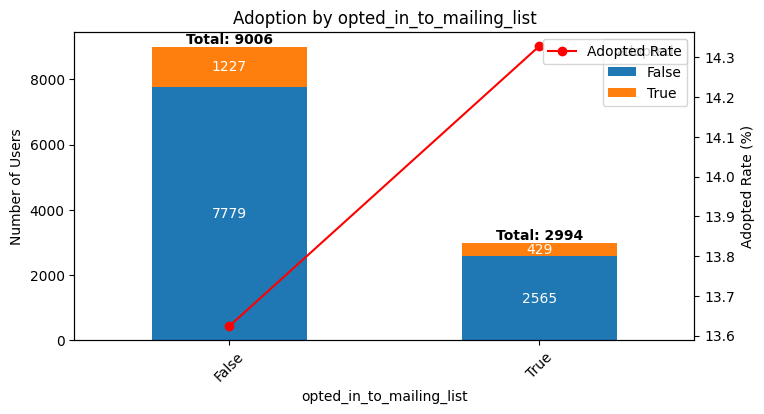

Chi-Squared Statistic: 0.8789863657841395
P-Value: 0.34847945597884034
Degrees of Freedom: 1
Fail to reject the null hypothesis: No significant difference in adoption rates across opted_in_to_mailing_list.


In [20]:
plot_adoption_by_category('opted_in_to_mailing_list')
chiSquaredTest('opted_in_to_mailing_list')

Users who opted in to mailing have a slightly higher adoption rate (less than 1%) compared to those who did not opt in, but the non-opted-in group has a larger user base. The chi-squared test indicates that this difference is not statistically significant, suggesting that mailing opt-in status has no meaningful impact on the adoption rate.

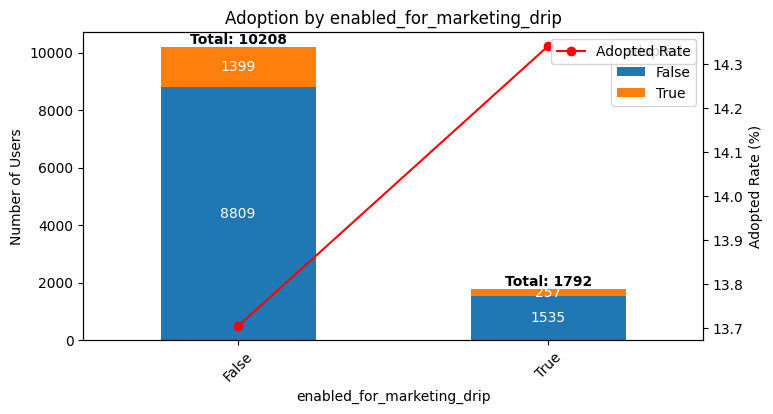

Chi-Squared Statistic: 0.46716408473039095
P-Value: 0.49429472330968593
Degrees of Freedom: 1
Fail to reject the null hypothesis: No significant difference in adoption rates across enabled_for_marketing_drip.


In [21]:
plot_adoption_by_category('enabled_for_marketing_drip')
chiSquaredTest('enabled_for_marketing_drip')

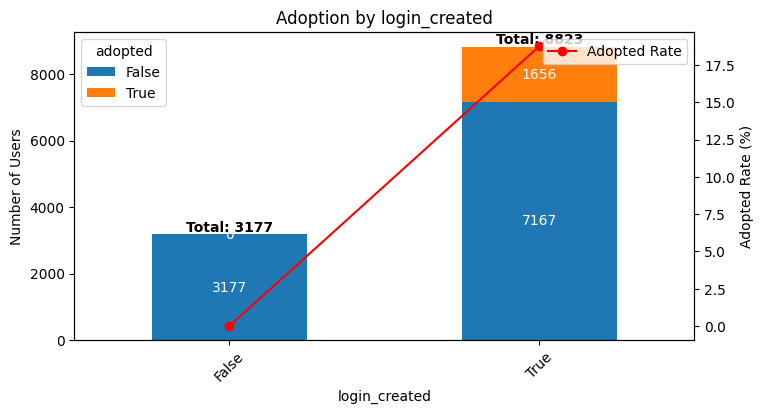

Chi-Squared Statistic: 690.1807791779025
P-Value: 4.083002921319187e-152
Degrees of Freedom: 1
Reject the null hypothesis: There is a significant difference in adoption rates across login_created.


In [22]:
plot_adoption_by_category('login_created')
chiSquaredTest('login_created')

Approximately 26% of users never logged back in after creating an account. Among those who did log in again, around 17% became adopted users.

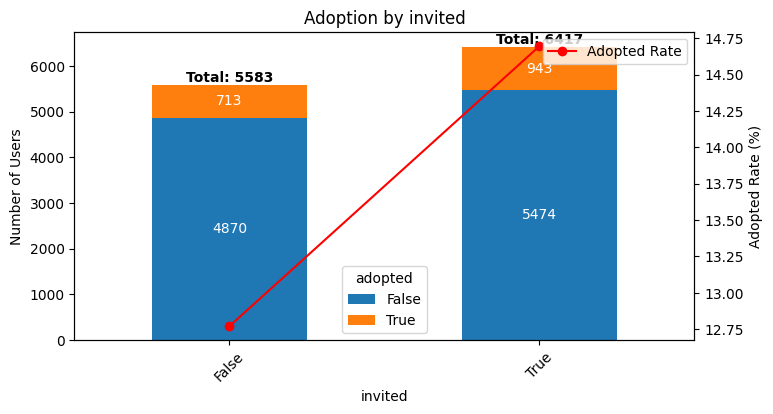

Chi-Squared Statistic: 9.133635762005955
P-Value: 0.0025095251588626395
Degrees of Freedom: 1
Reject the null hypothesis: There is a significant difference in adoption rates across invited.


In [23]:
plot_adoption_by_category('invited')
chiSquaredTest('invited')

Users who created accounts through invitations have an adoption rate about 2% higher than others. This difference is statistically significant, indicating that the invitation status is correlated with the adoption rate.

In [24]:
# adoption rate by organization
org_adoption = user_df.groupby(['org_id', 'adopted']).size().unstack(fill_value=0)
org_adoption['adoption_rate'] = round(org_adoption[True]/(org_adoption[False] + org_adoption[True]) *100, 2)
org_adoption['total_count'] = org_adoption[False] + org_adoption[True]
org_adoption = org_adoption.reset_index()[['org_id', 'adoption_rate', 'total_count']]
org_adoption = org_adoption.sort_values(by='adoption_rate', ascending=False)
org_adoption.head()

adopted,org_id,adoption_rate,total_count
387,387,58.33,12
235,235,46.15,13
270,270,42.86,14
399,399,38.46,13
400,400,37.50,8


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


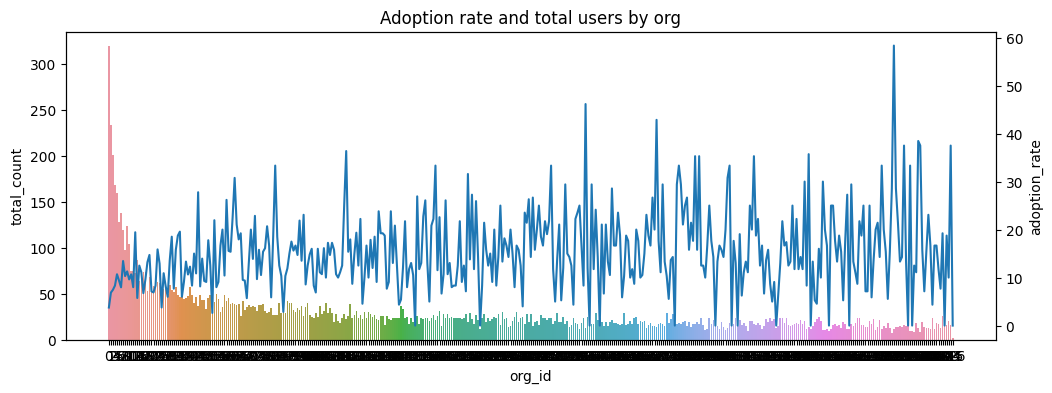

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 4))
sns.barplot(org_adoption, x='org_id', y='total_count', ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(org_adoption, x='org_id', y='adoption_rate', ax=ax2)
plt.title('Adoption rate and total users by org')
plt.show()

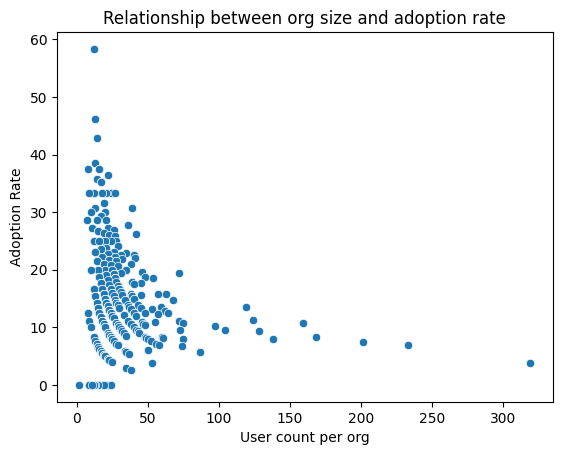

In [26]:
sns.scatterplot(org_adoption, x='total_count', y='adoption_rate')
plt.xlabel('User count per org')
plt.ylabel('Adoption Rate')
plt.title('Relationship between org size and adoption rate')
plt.show()

Small orgs tend to have higher adoption rate.

In [27]:
user_df = user_df.join(org_adoption['total_count'], how='left', on='org_id')
user_df = user_df.rename(columns={'total_count': 'org_user_count'})
user_df.head()

,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,login_created,invited,adopted,org_user_count
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,True,False,11,True,True,False,75
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,False,False,1,True,True,True,233
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,False,False,94,True,True,False,32
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,False,False,1,True,True,False,233
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,False,False,193,True,True,False,16


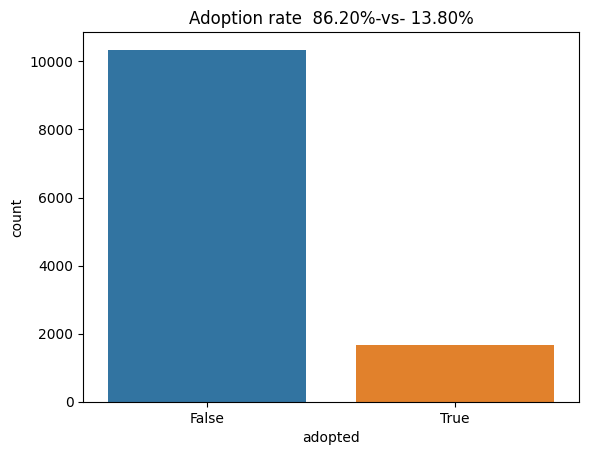

In [28]:
unAdoptedRate = user_df[user_df['adopted'] == False]['adopted'].count()/len(user_df) * 100
adoptedRate = user_df[user_df['adopted'] == True]['adopted'].count()/len(user_df) * 100

sns.countplot(data=user_df, x='adopted')
plt.title(f"Adoption rate {unAdoptedRate: .2f}%-vs-{adoptedRate: .2f}%")
plt.show()

# Modeling

In [29]:
def metrics_summary(y_test, y_pred, y_pred_prob):
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    if y_pred_prob is not None:
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"ROC-AUC Score: {roc_auc:.4f}")

In [30]:
def plot_target_ratio(y_train, y_test):
    fig, axes = plt.subplots(1,2, figsize=(8,5))
    axes[0].bar(x=[0,1], height=[y_train[y_train == 0].count(), y_train[y_train == 1].count()])
    unRetainedRatioTrain = y_train[y_train == 0].count()/len(y_train) * 100
    retainedRatioTrain = y_train[y_train == 1].count()/len(y_train) * 100
    axes[0].set_title(f"Train data Y {unRetainedRatioTrain: .2f}%-vs-{retainedRatioTrain: .2f}%")
    
    axes[1].bar(x=[0,1], height=[y_test[y_test == 0].count(), y_test[y_test == 1].count()])
    unRetainedRatioTest = y_test[y_test == 0].count()/len(y_test) * 100
    retainedRatioTest = y_test[y_test == 1].count()/len(y_test) * 100
    axes[1].set_title(f"Test data Y {unRetainedRatioTest: .2f}%-vs-{retainedRatioTest: .2f}%")

    plt.tight_layout()
    plt.show()

In [31]:
#Exclude opted_in_to_mailing_list and enabled_for_marketing_drip as they showed no statistically significant impact on the adoption rate during the EDA.
modeling_data = user_df.reset_index()[['creation_source', 'login_created', 'invited', 'org_user_count', 'adopted']]
modeling_data.head()

,creation_source,login_created,invited,org_user_count,adopted
0,GUEST_INVITE,True,True,75,False
1,ORG_INVITE,True,True,233,True
2,ORG_INVITE,True,True,32,False
3,GUEST_INVITE,True,True,233,False
4,GUEST_INVITE,True,True,16,False


In [32]:
modeling_data = pd.get_dummies(modeling_data, columns=['creation_source', 'login_created', 'invited'], drop_first=True, dtype='int')
modeling_data.head()

,org_user_count,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,login_created_True,invited_True
0,75,False,0,0,0,0,1,1
1,233,True,1,0,0,0,1,1
2,32,False,1,0,0,0,1,1
3,233,False,0,0,0,0,1,1
4,16,False,0,0,0,0,1,1


In [33]:
X = modeling_data.drop(['adopted'], axis=1)
y = modeling_data['adopted']
X.shape, y.shape

((12000, 7), (12000,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
scalar = MinMaxScaler()
X_train['org_user_count'] = scalar.fit_transform(X_train[['org_user_count']])
X_test['org_user_count'] = scalar.transform(X_test[['org_user_count']])
X_train.head()

,org_user_count,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,login_created_True,invited_True
5842,0.063091,1,0,0,0,1,1
8713,0.047319,0,0,0,0,1,1
2840,0.044164,1,0,0,0,1,1
1436,0.066246,0,1,0,0,1,0
10876,0.053628,0,0,0,1,1,0


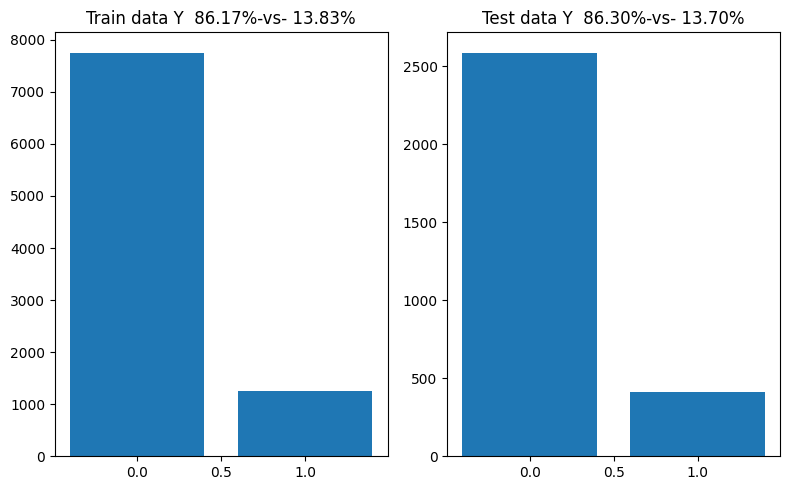

In [36]:
plot_target_ratio(y_train, y_test)

In [37]:
# Logistic Regression
lg = LogisticRegressionCV(class_weight='balanced', cv=5, scoring='f1')
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_pred_prob = lg.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

       False       0.97      0.40      0.57      2589
        True       0.20      0.93      0.33       411

    accuracy                           0.48      3000
   macro avg       0.59      0.67      0.45      3000
weighted avg       0.87      0.48      0.54      3000



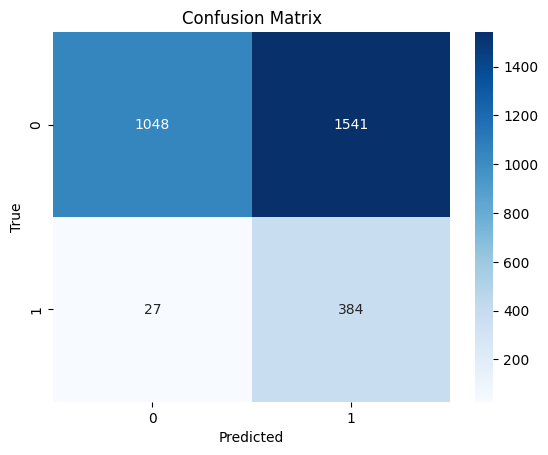

ROC-AUC Score: 0.7219


In [38]:
metrics_summary(y_test, y_pred, y_pred_prob)

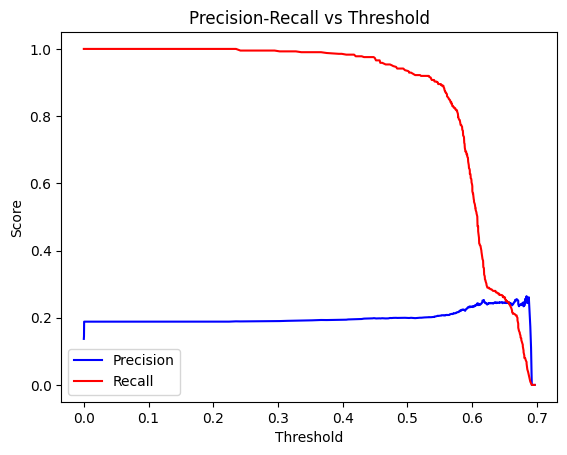

In [39]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

In [40]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

       False       0.91      0.58      0.71      2589
        True       0.20      0.65      0.30       411

    accuracy                           0.59      3000
   macro avg       0.56      0.62      0.50      3000
weighted avg       0.82      0.59      0.65      3000



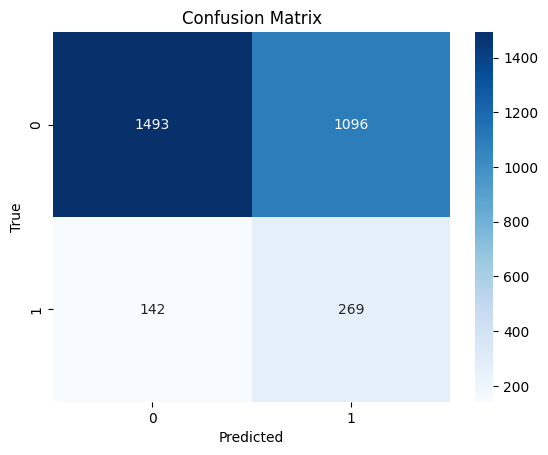

ROC-AUC Score: 0.6726


In [41]:
metrics_summary(y_test, y_pred, y_pred_prob)

In [42]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred_prob = gb.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

       False       0.86      1.00      0.93      2589
        True       0.40      0.00      0.01       411

    accuracy                           0.86      3000
   macro avg       0.63      0.50      0.47      3000
weighted avg       0.80      0.86      0.80      3000



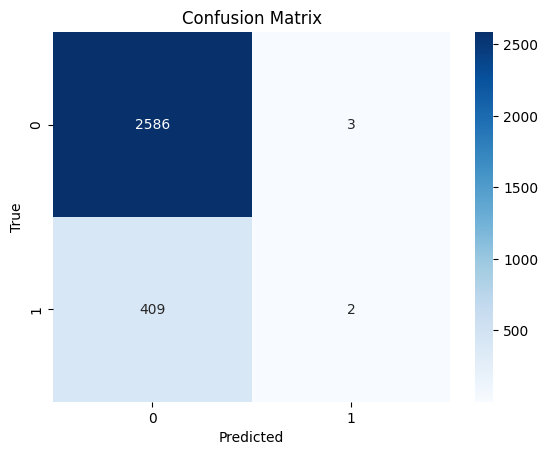

ROC-AUC Score: 0.7073


In [43]:
metrics_summary(y_test, y_pred, y_pred_prob)

Logistic regression stood out with the best performance and provided the highest level of interpretability among the models.

In [44]:
# Logistic Regression Coefficient
features = pd.DataFrame({'Feature':X_train.columns ,'Coefficient':lg.coef_[0]})
features

,Feature,Coefficient
0,org_user_count,-1.698546
1,creation_source_ORG_INVITE,-0.306992
2,creation_source_PERSONAL_PROJECTS,-0.503163
3,creation_source_SIGNUP,-0.870572
4,creation_source_SIGNUP_GOOGLE_AUTH,-0.810228
5,login_created_True,8.327321
6,invited_True,-0.465554


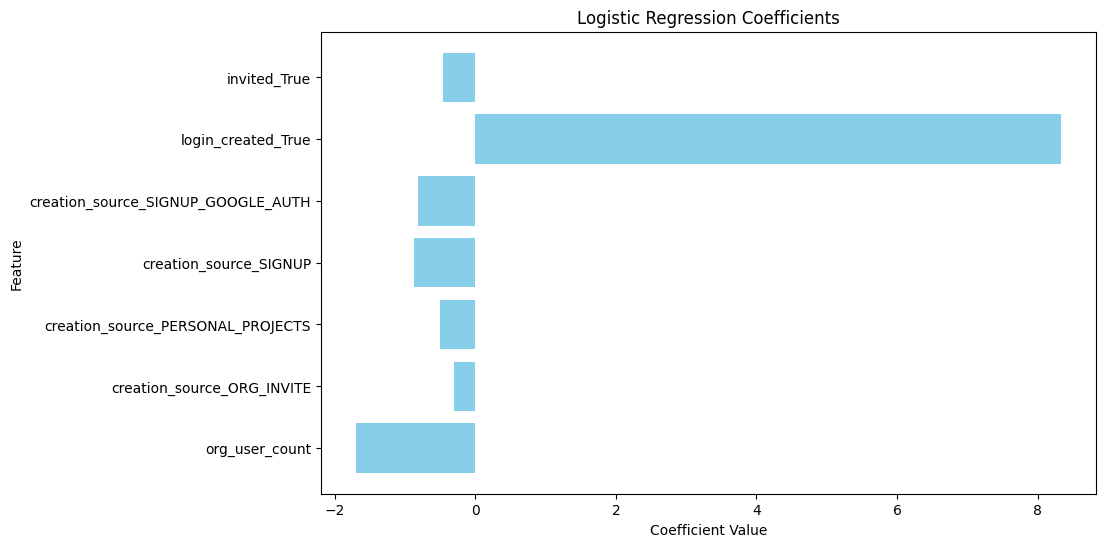

In [45]:
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

## Conclusion

Both the EDA and Logistic Regression results indicate that org_user_count has a negative correlation with the adoption rate—larger organizations tend to have lower adoption rates. Although smaller organizations have a higher average adoption rate, their rates are more volatile, making them less predictable. Additionally, creation_source is a strong predictor of user adoption, whereas enabled_for_marketing_drip and opted_in_to_mailing_list showed no statistical significance and had no impact on adoption.